In [1]:
import json
import pandas as pd
from glob import glob

In [2]:
lot = {}
base_path = 'datasets/CNREXT/'
images = glob(base_path + '*/*/*/*/*')
csvs = glob(base_path + '*.csv')
txts = glob(base_path + 'labels/camera*.txt')

for i in range(len(txts)):
    txt = txts[i]
    txt_data = open(txt, 'r').read()
    txt_data = txt_data.split('\n')

    for item in txt_data:
        try:
            path, label = item.split(' ')
            weather, date, camera, name = path.split('/')
            name = name.split('.jpg')[0]
            _, name_date, name_time, _, slotId = name.split('_')
            name_time = name_time.split('.')
            name_time = ''.join(name_time)
            true_name = name_date + '_' + name_time + '.jpg'
            true_path = base_path + 'image/' + weather + '/' + date + '/' + camera + '/' + true_name

            if true_path not in lot:
                lot[true_path] = []
            temp = {
                'camera': str(int(camera.split('camera')[-1])-1),
                'slotid': str(slotId), 
                'label': str(label)
            }
            lot[true_path].append(temp)
        except:
            pass

coord = {}
for i in range(len(csvs)):
    csv = csvs[i]
    csv_data = pd.read_csv(csv)

    coord[str(i)] = {}

    for j in range(len(csv_data)):
        slotId = str(csv_data.iloc[j]['SlotId'])
        x = int(csv_data.iloc[j]['X'])
        y = int(csv_data.iloc[j]['Y'])
        w = int(csv_data.iloc[j]['W'])
        h = int(csv_data.iloc[j]['H'])
        coord[str(i)][slotId] = {
            "x": x, 
            "y": y, 
            "w": w, 
            "h": h,
            'x1': int(x * 1000/2592),
            'y1': int(y * 750/1944),
            'x2': int((x + w) * 1000/2592),
            'y2': int((y + h) * 750/1944)
        }

In [3]:
import mrcnn.model as modellib
from samples.coco import coco
from cv2 import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report

class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()
model = modellib.MaskRCNN(mode = "inference", model_dir = 'logs/', config = config)
model.load_weights('mask_rcnn_coco.h5', by_name = True)
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 
               'bus', 'train', 'truck', 'boat', 'traffic light', 
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 
               'kite', 'baseball bat', 'baseball glove', 'skateboard', 
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
               'teddy bear', 'hair drier', 'toothbrush']

Using TensorFlow backend.



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
true = {}
detected = {}
report = {}

In [7]:

for k in range(1,10):
    
    print('camera{}'.format(k))
    true[k] = []
    detected[k] = []

    for key, value in tqdm(lot.items()):
        if ('camera{}'.format(k)) in key:
            image = cv2.imread(key)
            # image = cv2.resize(image, (2592, 1944))
            result = model.detect([image])
            result = result[0]


            for item in value:
                coordinate = coord[item['camera']][item['slotid']]
                x1 = coordinate['x1']
                y1 = coordinate['y1']
                x2 = coordinate['x2']
                y2 = coordinate['y2']
                x = coordinate['x']
                y = coordinate['y']
                label = item['label']

                # cv2.rectangle(image, (x1, y1), (x2, y2), (255,255,255), 2)
                marker = 0

                for i in range(len(result['rois'])):
                    if class_names[result['class_ids'][i]] == 'car':
                        y1_roi, x1_roi, y2_roi, x2_roi = result['rois'][i]
                        x = int((x1_roi + x2_roi) / 2)
                        y = int((y1_roi + y2_roi) / 2)

                        # cv2.circle(image, (x, y), 3, (255,255,255), 2)

                        if x1 < x < x2 and y1 < y < y2:
                            marker = 1
                            break

                true[k].append(int(label))
                detected[k].append(marker)

            # cv2.imshow('image', image)
            # cv2.waitKey(0)

    report[k] = classification_report(true[k], detected[k], output_dict=True)
    print(report[k])

  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

camera1


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.5550587410135016, 'recall': 0.9881379740908381, 'f1-score': 0.710829169707517, 'support': 6407}, '1': {'precision': 0.982362497099095, 'recall': 0.4547700902449506, 'f1-score': 0.6217228464419476, 'support': 9308}, 'accuracy': 0.6722239898186446, 'macro avg': {'precision': 0.7687106190562982, 'recall': 0.7214540321678944, 'f1-score': 0.6662760080747323, 'support': 15715}, 'weighted avg': {'precision': 0.8081509052925154, 'recall': 0.6722239898186446, 'f1-score': 0.6580514632515246, 'support': 15715}}
camera2


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.6289473684210526, 'recall': 0.9862448418156808, 'f1-score': 0.7680771290840922, 'support': 1454}, '1': {'precision': 0.9889807162534435, 'recall': 0.6796667928814842, 'f1-score': 0.8056552962298025, 'support': 2641}, 'accuracy': 0.7885225885225885, 'macro avg': {'precision': 0.8089640423372481, 'recall': 0.8329558173485825, 'f1-score': 0.7868662126569473, 'support': 4095}, 'weighted avg': {'precision': 0.8611446997092931, 'recall': 0.7885225885225885, 'f1-score': 0.792312523328737, 'support': 4095}}
camera3


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.6438809261300992, 'recall': 0.9968300414533041, 'f1-score': 0.7823923444976076, 'support': 4101}, '1': {'precision': 0.99583600256246, 'recall': 0.5789571694599628, 'f1-score': 0.7322185586434292, 'support': 5370}, 'accuracy': 0.7598986379474184, 'macro avg': {'precision': 0.8198584643462796, 'recall': 0.7878936054566335, 'f1-score': 0.7573054515705184, 'support': 9471}, 'weighted avg': {'precision': 0.8434373362707156, 'recall': 0.7598986379474184, 'f1-score': 0.7539441098827899, 'support': 9471}}
camera4


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.693373088390882, 'recall': 0.99861476658817, 'f1-score': 0.8184604904632151, 'support': 7219}, '1': {'precision': 0.9983816151480822, 'recall': 0.6592925082825692, 'f1-score': 0.7941555097837281, 'support': 9357}, 'accuracy': 0.8070704633204633, 'macro avg': {'precision': 0.8458773517694821, 'recall': 0.8289536374353697, 'f1-score': 0.8063080001234716, 'support': 16576}, 'weighted avg': {'precision': 0.8655476048524603, 'recall': 0.8070704633204633, 'f1-score': 0.8047405517435022, 'support': 16576}}
camera5


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.757201646090535, 'recall': 0.9985389271550824, 'f1-score': 0.8612836438923395, 'support': 9582}, '1': {'precision': 0.9982930992440868, 'recall': 0.7274342572850035, 'f1-score': 0.8416075650118203, 'support': 11256}, 'accuracy': 0.8520971302428256, 'macro avg': {'precision': 0.8777473726673108, 'recall': 0.862986592220043, 'f1-score': 0.85144560445208, 'support': 20838}, 'weighted avg': {'precision': 0.8874312936908988, 'recall': 0.8520971302428256, 'f1-score': 0.8506552753406972, 'support': 20838}}
camera6


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.7629539951573849, 'recall': 0.9990488268864933, 'f1-score': 0.8651839648544756, 'support': 9462}, '1': {'precision': 0.9988338947913967, 'recall': 0.724121735863235, 'f1-score': 0.8395774341102156, 'support': 10646}, 'accuracy': 0.8534911478018699, 'macro avg': {'precision': 0.8808939449743909, 'recall': 0.8615852813748641, 'f1-score': 0.8523806994823455, 'support': 20108}, 'weighted avg': {'precision': 0.8878384894633173, 'recall': 0.8534911478018699, 'f1-score': 0.8516268171369805, 'support': 20108}}
camera7


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.7770677244013515, 'recall': 0.9984898537045777, 'f1-score': 0.8739724895699946, 'support': 10595}, '1': {'precision': 0.9978666666666667, 'recall': 0.7114744747599582, 'f1-score': 0.8306787280093235, 'support': 10519}, 'accuracy': 0.8554987212276215, 'macro avg': {'precision': 0.8874671955340091, 'recall': 0.8549821642322679, 'f1-score': 0.8523256087896591, 'support': 21114}, 'weighted avg': {'precision': 0.8870698118167559, 'recall': 0.8554987212276215, 'f1-score': 0.8524035268979904, 'support': 21114}}
camera8


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.7511233317684931, 'recall': 0.9967073062205215, 'f1-score': 0.8566620774055378, 'support': 11237}, '1': {'precision': 0.9959664231985174, 'recall': 0.7111387872655095, 'f1-score': 0.8297910990009082, 'support': 12847}, 'accuracy': 0.8443780102972928, 'macro avg': {'precision': 0.8735448774835053, 'recall': 0.8539230467430154, 'f1-score': 0.843226588203223, 'support': 24084}, 'weighted avg': {'precision': 0.8817286795347081, 'recall': 0.8443780102972928, 'f1-score': 0.8423284343410851, 'support': 24084}}
camera9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4081/4081 [04:37<00:00, 14.71it/s]

{'0': {'precision': 0.7683211879554517, 'recall': 0.9976789858953758, 'f1-score': 0.8681062606804412, 'support': 5601}, '1': {'precision': 0.9977156914426287, 'recall': 0.771153062610349, 'f1-score': 0.8699249272253714, 'support': 7363}, 'accuracy': 0.869021906818883, 'macro avg': {'precision': 0.8830184396990401, 'recall': 0.8844160242528625, 'f1-score': 0.8690155939529063, 'support': 12964}, 'weighted avg': {'precision': 0.8986074984441963, 'recall': 0.869021906818883, 'f1-score': 0.8691391858401388, 'support': 12964}}


In [6]:
for k in ['SUNNY', 'OVERCAST', 'RAINY']:
    print('{}'.format(k))
    true[k] = []
    detected[k] = []

    for key, value in tqdm(lot.items()):
        if ('{}'.format(k)) in key:
            image = cv2.imread(key)
            # image = cv2.resize(image, (2592, 1944))
            result = model.detect([image])
            result = result[0]


            for item in value:
                coordinate = coord[item['camera']][item['slotid']]
                x1 = coordinate['x1']
                y1 = coordinate['y1']
                x2 = coordinate['x2']
                y2 = coordinate['y2']
                x = coordinate['x']
                y = coordinate['y']
                label = item['label']

                # cv2.rectangle(image, (x1, y1), (x2, y2), (255,255,255), 2)
                marker = 0

                for i in range(len(result['rois'])):
                    if class_names[result['class_ids'][i]] == 'car':
                        y1_roi, x1_roi, y2_roi, x2_roi = result['rois'][i]
                        x = int((x1_roi + x2_roi) / 2)
                        y = int((y1_roi + y2_roi) / 2)

                        # cv2.circle(image, (x, y), 3, (255,255,255), 2)

                        if x1 < x < x2 and y1 < y < y2:
                            marker = 1
                            break

                true[k].append(int(label))
                detected[k].append(marker)

            # cv2.imshow('image', image)
            # cv2.waitKey(0)

    report[k] = classification_report(true[k], detected[k], output_dict=True)
    print(report[k])

  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

SUNNY


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.6297364593348618, 'recall': 0.995285408143386, 'f1-score': 0.7713957842604336, 'support': 25665}, '1': {'precision': 0.9946495688702189, 'recall': 0.5996321275291232, 'f1-score': 0.748203831825439, 'support': 37513}, 'accuracy': 0.7603596188546646, 'macro avg': {'precision': 0.8121930141025404, 'recall': 0.7974587678362546, 'f1-score': 0.7597998080429363, 'support': 63178}, 'weighted avg': {'precision': 0.8464097550707169, 'recall': 0.7603596188546646, 'f1-score': 0.7576251724700327, 'support': 63178}}
OVERCAST


  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

{'0': {'precision': 0.7865833114962753, 'recall': 0.9973892818151612, 'f1-score': 0.8795311845960654, 'support': 21067}, '1': {'precision': 0.9968625213918996, 'recall': 0.7540127718329306, 'f1-score': 0.8585957844052473, 'support': 23176}, 'accuracy': 0.8699003232149719, 'macro avg': {'precision': 0.8917229164440874, 'recall': 0.8757010268240459, 'f1-score': 0.8690634845006564, 'support': 44243}, 'weighted avg': {'precision': 0.8967347697730873, 'recall': 0.8699003232149719, 'f1-score': 0.8685645043342748, 'support': 44243}}
RAINY


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4081/4081 [10:37<00:00,  6.40it/s]

{'0': {'precision': 0.78790658882402, 'recall': 0.9983092042692592, 'f1-score': 0.8807159837784925, 'support': 18926}, '1': {'precision': 0.9976408139191979, 'recall': 0.7268235041357826, 'f1-score': 0.8409670001864397, 'support': 18618}, 'accuracy': 0.8636799488600042, 'macro avg': {'precision': 0.8927737013716089, 'recall': 0.8625663542025208, 'f1-score': 0.8608414919824661, 'support': 37544}, 'weighted avg': {'precision': 0.8919134022382013, 'recall': 0.8636799488600042, 'f1-score': 0.8610045365028469, 'support': 37544}}


In [8]:
print(report)

{'all': {'0': {'precision': 0.7172131147540983, 'recall': 0.9968320692071034, 'f1-score': 0.8342149202748002, 'support': 65658}, '1': {'precision': 0.9961272784821911, 'recall': 0.674606276873416, 'f1-score': 0.8044295423106994, 'support': 79307}, 'accuracy': 0.820549787879833, 'macro avg': {'precision': 0.8566701966181447, 'recall': 0.8357191730402598, 'f1-score': 0.8193222312927497, 'support': 144965}, 'weighted avg': {'precision': 0.8698006054089726, 'recall': 0.820549787879833, 'f1-score': 0.8179200286099229, 'support': 144965}}, 'SUNNY': {'0': {'precision': 0.6297364593348618, 'recall': 0.995285408143386, 'f1-score': 0.7713957842604336, 'support': 25665}, '1': {'precision': 0.9946495688702189, 'recall': 0.5996321275291232, 'f1-score': 0.748203831825439, 'support': 37513}, 'accuracy': 0.7603596188546646, 'macro avg': {'precision': 0.8121930141025404, 'recall': 0.7974587678362546, 'f1-score': 0.7597998080429363, 'support': 63178}, 'weighted avg': {'precision': 0.8464097550707169, 'r

In [16]:
temp = [
    report['SUNNY']['accuracy'] * 100,
    report['RAINY']['accuracy'] * 100,
    report['OVERCAST']['accuracy'] * 100
]
print(temp)

[76.03596188546646, 86.36799488600042, 86.9900323214972]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.bar(range(3), temp)
plt.xlabel("Cuaca")
plt.ylabel('Akurasi')
plt.xticks(range(3), ['cerah', 'hujan', 'berawan'])

for i, v in enumerate(temp):
    plt.text(i-.125, 1, '{:.2f}'.format(v))

plt.show()

Error: Error: Failed to connect to Jupyter notebook. 
http://localhost:8889/
Error: Invalid response: 500 Internal Server Error

In [45]:
camera_acc = [report[i]['accuracy'] * 100 for i in range(1, 10)]
print(camera_acc)

[67.22239898186446, 78.85225885225886, 75.98986379474184, 80.70704633204633, 85.20971302428256, 85.34911478018698, 85.54987212276215, 84.43780102972927, 86.9021906818883]


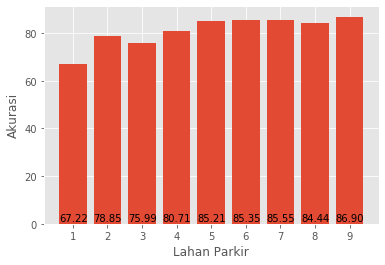

In [59]:
plt.bar(range(len(camera_acc)), camera_acc)
plt.xlabel("Lahan Parkir")
plt.ylabel('Akurasi')
plt.xticks(range(len(camera_acc)), range(1,10))

for i, v in enumerate(camera_acc):
    plt.text(i-.40, 1, '{:.2f}'.format(v))

plt.show()

In [5]:
print('{}'.format('All'))
true['all'] = []
detected['all'] = []

for key, value in tqdm(lot.items()):
    image = cv2.imread(key)
    # image = cv2.resize(image, (2592, 1944))
    result = model.detect([image])
    result = result[0]


    for item in value:
        coordinate = coord[item['camera']][item['slotid']]
        x1 = coordinate['x1']
        y1 = coordinate['y1']
        x2 = coordinate['x2']
        y2 = coordinate['y2']
        x = coordinate['x']
        y = coordinate['y']
        label = item['label']

        # cv2.rectangle(image, (x1, y1), (x2, y2), (255,255,255), 2)
        marker = 0

        for i in range(len(result['rois'])):
            if class_names[result['class_ids'][i]] == 'car':
                y1_roi, x1_roi, y2_roi, x2_roi = result['rois'][i]
                x = int((x1_roi + x2_roi) / 2)
                y = int((y1_roi + y2_roi) / 2)

                # cv2.circle(image, (x, y), 3, (255,255,255), 2)

                if x1 < x < x2 and y1 < y < y2:
                    marker = 1
                    break

        true['all'].append(int(label))
        detected['all'].append(marker)

    # cv2.imshow('image', image)
    # cv2.waitKey(0)

report['all'] = classification_report(true['all'], detected['all'], output_dict=True)
print(report['all'])

  0%|                                                                                                                                        | 0/4081 [00:00<?, ?it/s]

All


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4081/4081 [41:08<00:00,  1.65it/s]

{'0': {'precision': 0.7172131147540983, 'recall': 0.9968320692071034, 'f1-score': 0.8342149202748002, 'support': 65658}, '1': {'precision': 0.9961272784821911, 'recall': 0.674606276873416, 'f1-score': 0.8044295423106994, 'support': 79307}, 'accuracy': 0.820549787879833, 'macro avg': {'precision': 0.8566701966181447, 'recall': 0.8357191730402598, 'f1-score': 0.8193222312927497, 'support': 144965}, 'weighted avg': {'precision': 0.8698006054089726, 'recall': 0.820549787879833, 'f1-score': 0.8179200286099229, 'support': 144965}}


In [ ]:
acc = [85.43, 98.85]

plt.bar(range(len(acc)), acc)
plt.xlabel("Lahan Parkir")
plt.ylabel('Akurasi')
plt.xticks(range(len(acc)), range(1,10))

for i, v in enumerate(acc):
    plt.text(i-.40, 1, '{:.2f}'.format(v))

plt.show()